## Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
from torchvision.transforms import v2

In [2]:
import spoofdet.config as config
from spoofdet.model_utils import gpu_transforms_train, gpu_transforms_val, evaluate_model, train_model, checkImage, checkAugmentedImage, create_subset, checkDatasetDistribution, display_train_result, save_results, analyze_spoof_types, analyze_dataset_spoof_distribution
from spoofdet.dataset import CelebASpoofDataset

## randomizer

In [3]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

## Model


In [4]:
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

for param in model.features.parameters():
    param.requires_grad = False

# Adjust the final layer for 2 classes (Live/Spoof)
# EfficientNet uses .classifier instead of .fc
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 2)

## preparation


In [5]:
import multiprocessing
from torch.utils.data import Subset


PROFILER_NAME = "efficientnetv2s_frozen"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
bbox_lookup = "../bbox_lookup.json"

num_cpus = multiprocessing.cpu_count()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)

device

device(type='cuda')

In [6]:


all_ds = CelebASpoofDataset(
    root_dir=config.ROOT_DIR,
    json_label_path=config.TRAIN_JSON,
    bbox_json_path=bbox_lookup,
    target_size = config.TARGET_SIZE,
    bbox_original_size = config.BBOX_ORGINAL_SIZE
)

test_ds = CelebASpoofDataset(
    root_dir=config.ROOT_DIR,
    json_label_path=config.TEST_JSON,
    bbox_json_path=bbox_lookup,
    target_size = config.TARGET_SIZE,
    bbox_original_size = config.BBOX_ORGINAL_SIZE
)

train_ds = Subset(all_ds, range(0, int(0.5 * len(all_ds))))
val_ds = Subset(all_ds, range(int(0.5 * len(all_ds)), len(all_ds)))


Loading BBox Cache into RAM...
Loading BBox Cache into RAM...


In [7]:
len(train_ds)

247202

In [8]:

np.random.seed(seed)

small_train_ds = create_subset(train_ds.dataset, total_size=3000, spoof_percent=config.SPOOF_PERCENT)
small_val_ds = create_subset(val_ds.dataset, total_size=1000, spoof_percent=config.SPOOF_PERCENT)
small_test_ds = create_subset(test_ds, total_size=400)
print(f"Created Balanced Train: {len(small_train_ds)} images")

 Scanning internal label dict for class balance...
 Found: 162462 Live | 331943 Spoof
 Scanning internal label dict for class balance...
 Found: 162462 Live | 331943 Spoof
 Scanning internal label dict for class balance...
 Found: 19923 Live | 47247 Spoof
Created Balanced Train: 3000 images


In [9]:
len(small_train_ds)

3000

In [10]:
len(small_val_ds)

1000

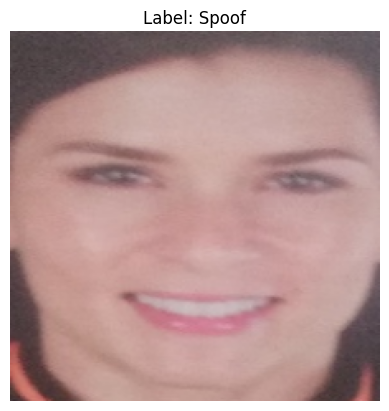

In [11]:

# 1 = spoof  0 = live 
checkImage(small_train_ds, 210)

In [12]:
# check distribution of live and spoof in small_test_ds
checkDatasetDistribution(small_test_ds)

Live count: 200, Spoof count: 200


In [13]:
checkDatasetDistribution(small_train_ds)

Live count: 900, Spoof count: 2100


In [14]:
checkDatasetDistribution(small_val_ds)

Live count: 300, Spoof count: 700


## Data Loader

In [15]:
from torch.utils.data import DataLoader
small_train_loader = DataLoader(small_train_ds, 
                                batch_size=config.BATCH_SIZE, 
                                shuffle=True,
                                num_workers=config.WORKERS,
                                pin_memory=True,
                                persistent_workers=True
          
                   
)
small_val_loader = DataLoader(small_val_ds, 
                              batch_size=config.BATCH_SIZE,
                              shuffle=False,
                              num_workers=config.WORKERS,
                              pin_memory=True,
                              persistent_workers=True
                
                    
)
small_test_loader = DataLoader(small_test_ds, 
                               batch_size=config.BATCH_SIZE, 
                               shuffle=False,
                                num_workers=config.WORKERS,
                                pin_memory=True,
                                persistent_workers=True
                                )

In [16]:
sample_img, sample_label = small_train_ds[0]
sample_img.shape, sample_label

(torch.Size([3, 224, 224]), tensor(1))

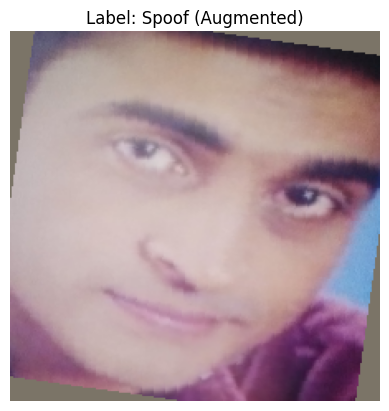

In [17]:
checkAugmentedImage(small_train_ds, 2, gpu_transforms=gpu_transforms_train)

## Train

In [18]:
model, history = train_model(model=model, 
                             device=device, 
                             train_loader=small_train_loader, 
                             val_loader=small_val_loader,      
                             criterion=criterion, 
                             optimizer=optimizer, 
                             epochs=5, 
                             early_stopping_limit=config.EARLY_STOPPING_LIMIT,
                             train_transforms=gpu_transforms_train,
                             val_transforms=gpu_transforms_val,
                             profiler_log_name=PROFILER_NAME
                             )

Epoch [1/5] | Time: 1m 23s Train Loss: 0.5888 | Val Loss: 0.5438 | Val Precision: 0.85% | Val Accuracy: 0.81% | Val Recall: 0.88% | Val F1: 0.86%
  -> New best model saved!
Epoch [2/5] | Time: 0m 14s Train Loss: 0.4850 | Val Loss: 0.4669 | Val Precision: 0.90% | Val Accuracy: 0.85% | Val Recall: 0.89% | Val F1: 0.89%
  -> New best model saved!
Epoch [3/5] | Time: 0m 14s Train Loss: 0.4284 | Val Loss: 0.4377 | Val Precision: 0.93% | Val Accuracy: 0.86% | Val Recall: 0.87% | Val F1: 0.90%
  -> New best model saved!
Epoch [4/5] | Time: 0m 14s Train Loss: 0.3872 | Val Loss: 0.4105 | Val Precision: 0.94% | Val Accuracy: 0.87% | Val Recall: 0.88% | Val F1: 0.91%
  -> New best model saved!
Epoch [5/5] | Time: 0m 13s Train Loss: 0.3628 | Val Loss: 0.4233 | Val Precision: 0.95% | Val Accuracy: 0.84% | Val Recall: 0.82% | Val F1: 0.88%
  -> No improvement. Counter: 1/30


D:\JoshFile\Github\spoofing-recognition\src\spoofdet\model_utils.py:359: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_loss.show()
D:\JoshFile\Github\spoofing-recognition\src\spoofdet\model_utils.py:369: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_precision.show()


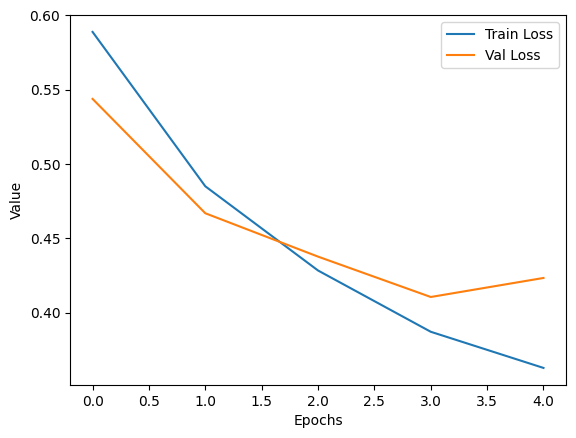

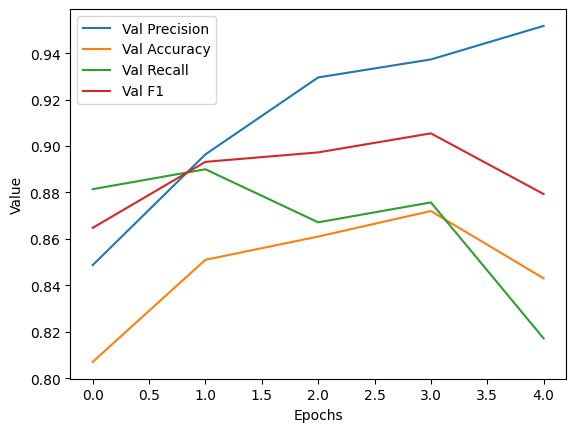

In [19]:




train_loss_fig, precision_fig = display_train_result(history)

## test


Confusion Matrix:
         Predicted Live | Predicted Spoof
Live           166     |         34
Spoof           38     |        162


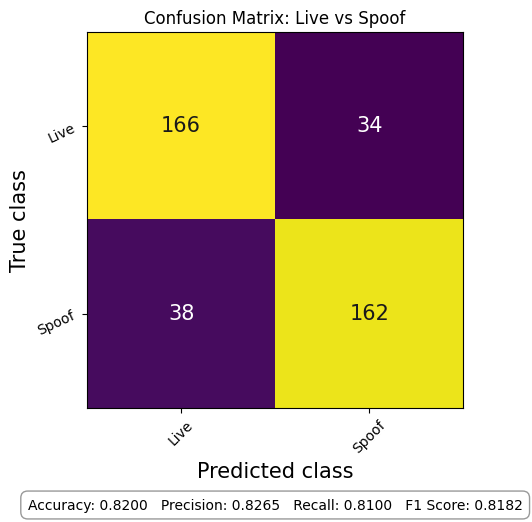

Accuracy: 0.8200
Precision: 0.8265
Recall:    0.8100
F1 Score:  0.8182


In [20]:
confusion_matrix, accuracy, precision, recall, f1 = evaluate_model(model=model, dataloader=small_test_loader, device=device, val_transforms=gpu_transforms_val)

In [21]:


save_results(model=model, confusion_matrix_fig=confusion_matrix, train_loss_fig=train_loss_fig, precision_fig=precision_fig)

Saving results to: train_results\train_12


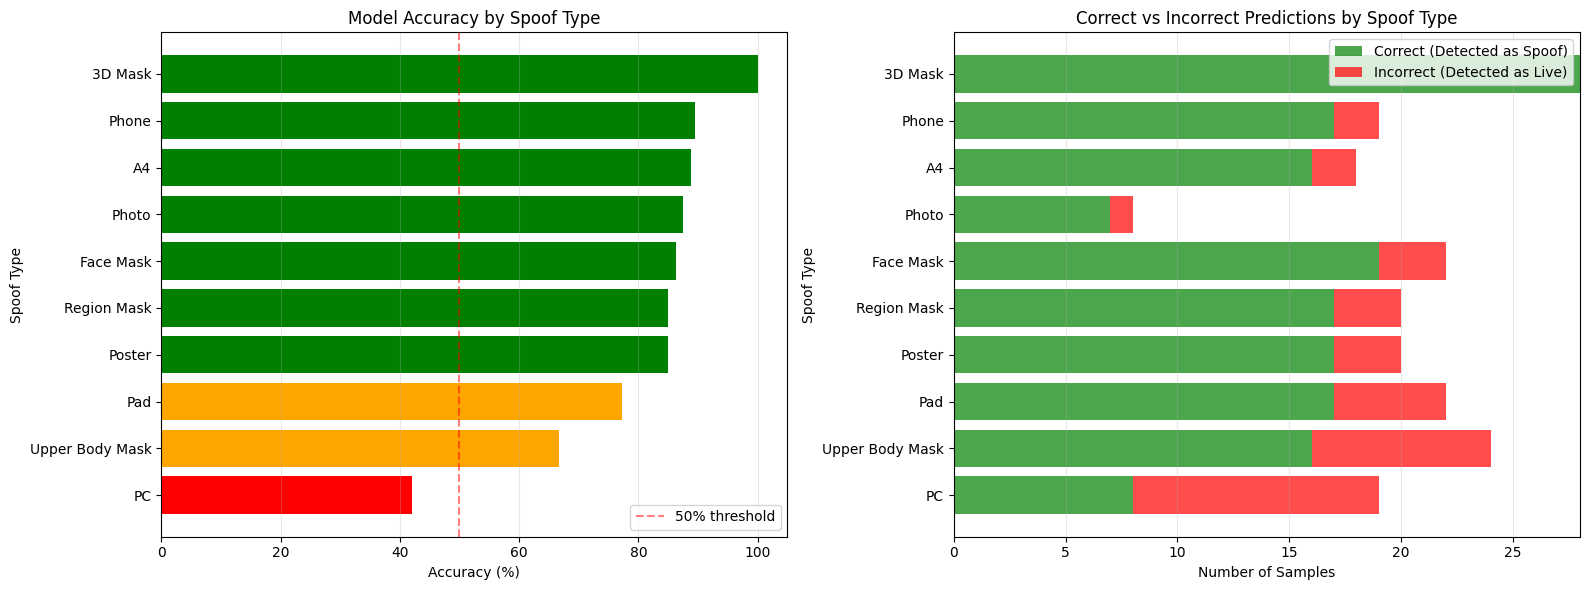


Spoof Type Analysis Results:
     Spoof Type  Type ID  Total  Correct  Incorrect  Accuracy (%)
             PC        7     19        8         11     42.105263
Upper Body Mask        5     24       16          8     66.666667
            Pad        8     22       17          5     77.272727
         Poster        2     20       17          3     85.000000
    Region Mask        6     20       17          3     85.000000
      Face Mask        4     22       19          3     86.363636
          Photo        1      8        7          1     87.500000
             A4        3     18       16          2     88.888889
          Phone        9     19       17          2     89.473684
        3D Mask       10     28       28          0    100.000000


Worst Performing Spoof Types (Accuracy < 70%):
     Spoof Type  Type ID  Total  Correct  Incorrect  Accuracy (%)
             PC        7     19        8         11     42.105263
Upper Body Mask        5     24       16          8     66.6666

In [22]:


# Run the analysis
spoof_analysis_df, spoof_fig = analyze_spoof_types(
    model=model,
    dataset=small_test_ds,
    device=device,
    val_transforms=gpu_transforms_val
)

In [23]:
# Check a few samples
for i in range(5):
    _, label = small_test_ds[i]
    print(f"Sample {i}: Label = {label.item()} ({'Live' if label.item() == 0 else 'Spoof'})")

Sample 0: Label = 1 (Spoof)
Sample 1: Label = 1 (Spoof)
Sample 2: Label = 0 (Live)
Sample 3: Label = 1 (Spoof)
Sample 4: Label = 0 (Live)


In [24]:
# Test with a known Live sample
img, label = small_test_ds[2]  # Adjust index to find a Live sample
print(f"True label: {'Live' if label == 0 else 'Spoof'}")

img = img.unsqueeze(0).to(device)
img = gpu_transforms_val(img)
output = model(img)
pred = torch.argmax(output, dim=1).item()
print(f"Predicted: {'Live' if pred == 0 else 'Spoof'}")

True label: Live
Predicted: Live


Analyzing spoof type distribution...


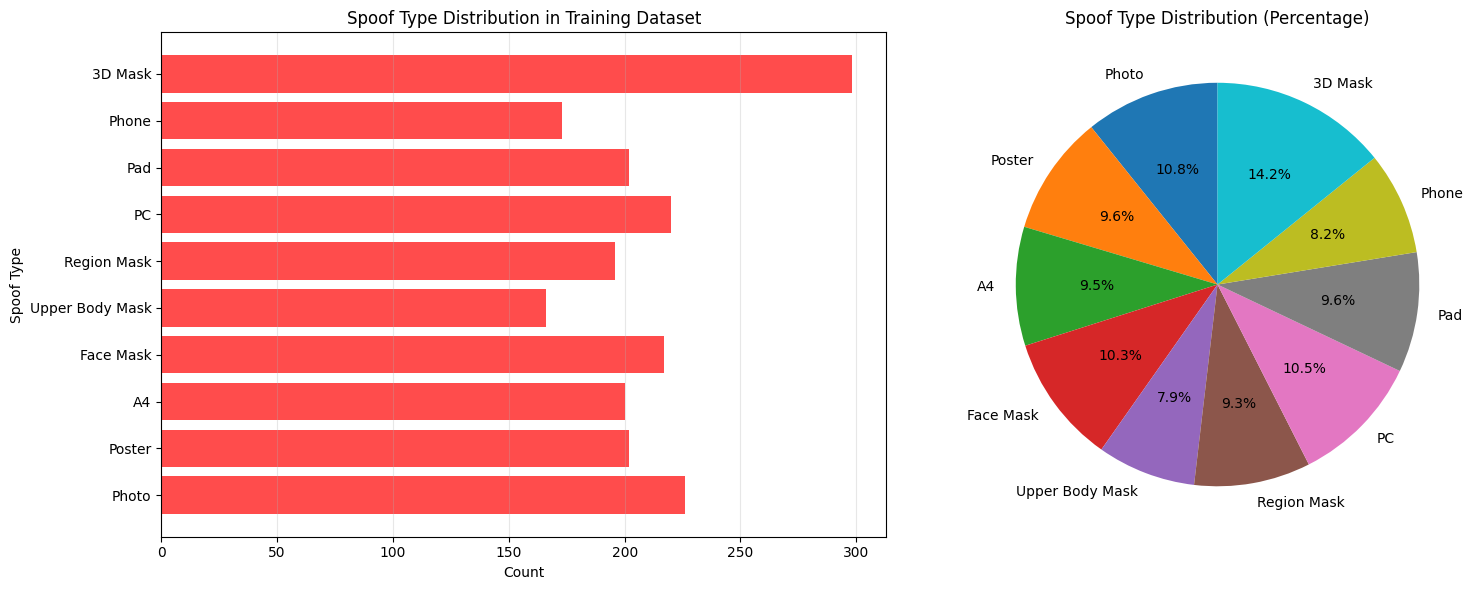


Spoof Type Distribution:
     Spoof Type  Type ID  Count  Percentage
          Photo        1    226        7.53
         Poster        2    202        6.73
             A4        3    200        6.67
      Face Mask        4    217        7.23
Upper Body Mask        5    166        5.53
    Region Mask        6    196        6.53
             PC        7    220        7.33
            Pad        8    202        6.73
          Phone        9    173        5.77
        3D Mask       10    298        9.93

Total samples: 3000
Live samples: 900 (30.00%)
Spoof samples: 2100 (70.00%)


In [25]:


# Analyze training dataset distribution
train_dist_df, train_dist_fig = analyze_dataset_spoof_distribution(small_train_ds)